In [1]:
# Preamble 

import matplotlib.pyplot as plt  
import numpy as np
from scipy.stats import norm
import scipy.stats as stats
import scipy as sc
from scipy import special as sp
import scipy.constants as constants 
import math
from tqdm.notebook import tqdm
import matplotlib.colors as mcolors
import time

In [2]:
def flow_basic2(r1=6e-2, r2=6e-2, length=400, steps=4000, flow_rate=1, cc=1.7e-6, c_ini=4e-4, T=273.15, plot=True, CH4_trans=1, H2_trans=1, CO_trans=1, fcheck=True, carrier=1):
        
    starttime=time.time()
    # Auto-params:
    # z=400 cm, or 4 m
    # r1 and r2 are 0.06 cm, or 6 mm; r1>r2 always
    # Flow rate is 100 cm/s, or 1 m/s
    # consumption constant of 1.7e-6 mol/cm^3*s (= 0.0017 mol/L*s) for the reaction of H2 (concentration per s)
    # initial concentration of 4e-4 mol/cm^3
    # standard T of 273.15 K
    # 'carrier' is the % relative to H2 amount of carrier gas 
    # scipy gas constant is in: m^2 * kg/s^2*K*mol
    
    # Set up the most important variables:
    z=steps
    xs=np.linspace(0,10,z)
    dx=xs[1]-xs[0] # gives us the real size of one cell in cm (z-wise); for gauss use only
    x1=round(r1/dx) # gives us number of steps for x-wise axis
    x2=round(r2/dx)
    dx1=r1/x1 # gives actual x-wise step size in cm
    dx2=r2/x2
    tube=np.zeros((2,4,x1,z)) # 2 tubes [gas, aq], 3 elements [H2O, CO, CH4, carrier], x steps, 4000 time steps (z)
    sq2p=np.sqrt(2*np.pi)
    T_std=273.15 
    T_ini=298.15
    p_std=1e5 #Pa, about 1 atm 
    rate_cnst=1.7e-6 # mol*cm-2*s-1
    gas_a=r1*length # cm2
    z_steps=np.linspace(0,length,z) 

    if T==T_ini:
        # Set Henry's law constant values: 
        hlc=[7.8e-4, 9.8e-4, 1.4e-5] # [mol/L*atm]
        # Diffusion coeffs for [H2O, CO, CH4]:
        D_aq=[4.5e-5, 2.03e-5, 1.49e-5] # Diffusion coeffs into water (cm^2/s)
        D_g=[0.756, 0.208, 0.21] # Diffusion coeffs into air (cm^2/s)
    else:
        # These temperature equations don't work if T=T*
        # Set initial HLC values:
        hlc_ini=[7.8e-4, 9.8e-4, 1.4e-5]
        # Set initial diffusion coeffs:
        D_aq_ini=[4.5e-5, 2.03e-5, 1.49e-5] 
        D_g_ini=[0.756, 0.208, 0.21]
        # Need initial viscosity values:
        viscosity_ini=[9e-5,1.5e-2,1.11e-4]
        # Enthalpy of dissolution aka temperature dependence constant C(K):
        C=[500,1300,1700] 
        
        D_aq,D_g,viscosity,hlc=np.zeros(3),np.zeros(3),np.zeros(3),np.zeros(3)
        for i in range(3):
            viscosity[i]=viscosity_ini[i]*np.exp(1000/(T)-1000/(T_ini)) # Andrade's equation; 1000 is an approximation for B 

            D_aq[i]=D_aq_ini[i]*T*viscosity_ini[i]/(T_ini*viscosity[i]) # Stokes-Einstein equation
            D_g[i]=D_g_ini[i]*T**(3/2)/T_ini**(3/2) # Chapman-Enskog theory; Omega = 1, pressure is controlled, other parameters cancel out

            hlc[i]=hlc_ini[i]*np.exp(-C[i]*((1/T)-(1/T_ini)))
            
    # Set up for a gaussian curve
    gauss=np.zeros((2,3,x1,z)) 
    gauss_full=np.zeros((x2,x2,z)) # First x2 will let us set a gauss for each particle at an x2, 2nd x2 will be the actual x2 array 
    t_zero=100 # Need an initial time or else the gauss_full gets wonky

    rescale_react=np.zeros((x2,z))
    rescale=np.zeros((2,3,z)) # 2 phases, 3 elements, and z points
    consumed_H2=[]
    consumed_CO=[]

    count_H2=0
    count_CO=0
    count_CH4=0
    count_gauss=True
    
    c_check=np.zeros((2,z))
    h_check=np.zeros(z)
    f_check=np.zeros(z)

    # Set dt and dz to begin
    t_tot=length/flow_rate 
    dt=t_tot/z
    dz=length/z
    print('dz:',dz,'\ndt_0:', length/(z*flow_rate))

    # Set H2 initial amounts:
    tube[0,0,:]=c_ini*dx1*dz
    tube[1,0,1:]=0 

    # CO:
    tube[0,1,:]=c_ini*dx1*dz/3
    tube[1,1,1:]=0 
    
    # CH4:
    tube[:,2,:,:]=0 
    
    # Carrier:
    tube[0,3,:,:]=c_ini*dx1*dz*carrier
    
    # Set initial flow rate parameters:
    f_ini=flow_rate 
    n=(c_ini*(1.333+carrier)*dz)
    vol_ini=(n*constants.R*T/p_std)
    
    for k in tqdm(range(z-2)): 

        t_tot=length/flow_rate # Gives us a decimal rate for the time needed to flow (cm*s/cm=s), ex: rate of 100 cm per second, so the full length of 400 cm takes 4 s
        t=t_tot*(k+1)/z # Current time (s)
        dt=t_tot/z # Takes the total time and divides by z to give us a scale for the step size (k) 
        t_full=t
        for c in range(x2): 
            # We'll create a false array that we'll fold over on itself to get better resolution of the full diffusion out to a far x:
            xs_full=np.linspace(-2*x2,2*x2,4*x2) 
            cs=c+math.floor(x2/2) # Sets c in the context of the full Gauss tube
            # Initial Gaussian diffusion from source point c:
            gauss_full[c,:,k]+=(np.exp(-(xs_full[math.floor(5*x2/2)-cs:math.floor(7*x2/2)-cs]*dx2)**2/(4*D_aq[2]*t_zero))/(np.sqrt(4*np.pi*D_aq[2]*t_zero))) # original gauss
            # "Reverb":
            gauss_full[c,:,k]+=np.flip(np.exp(-(xs_full[math.floor(3*x2/2)-cs:math.floor(5*x2/2)-cs]*dx2)**2/(4*D_aq[2]*t_zero))/(np.sqrt(4*np.pi*D_aq[2]*t_zero)))# reverb from x=0
            gauss_full[c,:,k]+=np.flip(np.exp(-(xs_full[math.floor(7*x2/2)-cs-1:math.floor(9*x2/2)-cs-1]*dx2)**2/(4*D_aq[2]*t_zero))/(np.sqrt(4*np.pi*D_aq[2]*t_zero))) # reverb from x=x2
            # "Reverb" again (any amount after this should be insignificant):
            gauss_full[c,c:,k]+=(np.exp(-(xs_full[1:math.floor(3*x2/2)-cs+1]*dx2)**2/(4*D_aq[2]*t_zero))/(np.sqrt(4*np.pi*D_aq[2]*t_zero)))# reverb from x=0
            gauss_full[c,:c,k]+=(np.exp(-(xs_full[math.floor(9*x2/2)-cs:4*x2]*dx2)**2/(4*D_aq[2]*t_zero))/(np.sqrt(4*np.pi*D_aq[2]*t_zero))) # reverb from x=x2

        for j in range(math.floor(z/x1)): 
            for nn in range(3): # Create Gauss functions for H2 and CO diffusion; "reverb" for better resolution:
                if j%2==0:
                    gauss[0,nn,:,k]+=(np.exp(-xs[x1*j:x1*(j+1)]*xs[x1*j:x1*(j+1)]/(4*D_g[nn]*t))/(np.sqrt(4*np.pi*D_g[nn]*t)))
                    gauss[1,nn,:x2,k]+=(np.exp(-xs[x2*j:x2*(j+1)]*xs[x2*j:x2*(j+1)]/(4*D_aq[nn]*t))/(np.sqrt(4*np.pi*D_aq[nn]*t)))
                else:
                    gauss[0,nn,:,k]+=np.flip(np.exp(-xs[x1*j:x1*(j+1)]*xs[x1*j:x1*(j+1)]/(4*D_g[nn]*t))/(np.sqrt(4*np.pi*D_g[nn]*t)))
                    gauss[1,nn,:x2,k]+=np.flip(np.exp(-xs[x2*j:x2*(j+1)]*xs[x2*j:x2*(j+1)]/(4*D_aq[nn]*t))/(np.sqrt(4*np.pi*D_aq[nn]*t)))
                
        if k>0:
            # Use the tube amounts from previous steps to set the amount for the current step:
            gauss[0,0,:,k]*=np.sum(gauss[0,0,:,k-1],axis=0)/np.sum(gauss[0,0,:,k],axis=0)
            gauss[0,1,:,k]*=np.sum(gauss[0,1,:,k-1],axis=0)/np.sum(gauss[0,1,:,k],axis=0)
            gauss[0,2,:,k]*=np.sum(gauss[0,2,:,k-1],axis=0)/np.sum(gauss[0,2,:,k],axis=0)

            gauss[1,0,:,k]*=np.sum(gauss[1,0,:,k-1],axis=0)/np.sum(gauss[1,0,:,k],axis=0)
            gauss[1,1,:,k]*=np.sum(gauss[1,1,:,k-1],axis=0)/np.sum(gauss[1,1,:,k],axis=0)
            gauss[1,2,:,k]*=np.sum(gauss[1,2,:,k-1],axis=0)/np.sum(gauss[1,2,:,k],axis=0)        

            p_H2=tube[0,0,0,k-1]*T*constants.R/(dz*dx1) # use PV=nRT to get pressure (not "true" pressure, units are [Pa][m^3]/[cm^2])
            if p_H2>101.325*tube[1,0,0,k-1]/(dz*dx2*hlc[0]): # use Henry's Law to find equilibrium; 101.325 is a conversion factor of atm to Pa and L to m^3:
                count_H2+=1
                H2_diff=H2_trans*dz*dx2*((tube[0,0,0,k-1]*hlc[0]*constants.R*T/(dz*dx1*101.325))-tube[1,0,0,k-1]/(dz*dx2))/(hlc[0]*constants.R*T/101.325+1) # Diffusion coefficient
                rescale[0,0,count_H2]=(H2_diff/gauss[0,0,0,1])*dz # gas
                rescale[1,0,count_H2]=(H2_diff/gauss[1,0,0,1])*dz # aq 
                rescale[1,0,count_H2]*=(np.sum(rescale[0,0,count_H2]*gauss[0,0,:,k-count_H2]))/(np.sum(rescale[1,0,count_H2]*gauss[1,0,:,k-count_H2])) # "Brute force" normalization
            if any((tube[0,0,:x2,k]-np.sum(rescale[0,0,:count_H2]*np.flip(gauss[0,0,:x2,k-count_H2:k],axis=1),axis=1))<0): # Make sure it never goes below zero
                count_H2-=1 # "deletes" last diffusion step; theoretically this portion should never be triggered
                print('H2 negative at k:',k)
                tube[0,0,:x1,k]-=np.sum(rescale[0,0,:count_H2]*np.flip(gauss[0,0,:x1,k-count_H2:k],axis=1),axis=1)
                tube[1,0,:x2,k]+=np.sum(rescale[1,0,:count_H2]*np.flip(gauss[1,0,:x2,k-count_H2:k],axis=1),axis=1)
            else:
                tube[0,0,:x1,k]-=np.sum(rescale[0,0,:count_H2]*np.flip(gauss[0,0,:x1,k-count_H2:k],axis=1),axis=1)
                tube[1,0,:x2,k]+=np.sum(rescale[1,0,:count_H2]*np.flip(gauss[1,0,:x2,k-count_H2:k],axis=1),axis=1)
            # Do the same thing for CO:
            p_CO=tube[0,1,0,k-1]*T*constants.R/(dz*dx1) 
            if p_CO>101.325*tube[1,1,0,k-1]/(dz*dx2*hlc[1]): 
                count_CO+=1
                CO_diff=CO_trans*dz*dx2*((tube[0,1,0,k-1]*hlc[1]*constants.R*T/(dz*dx1*101.325))-tube[1,1,0,k-1]/(dz*dx2))/((hlc[1]*constants.R*T/101.325)+1)
                rescale[0,1,count_CO]=(CO_diff/gauss[0,1,0,1])*dz # gas
                rescale[1,1,count_CO]=(CO_diff/gauss[1,1,0,1])*dz # aq
                rescale[1,1,count_CO]*=(np.sum(rescale[0,1,count_CO]*gauss[0,1,:,k-count_CO]))/(np.sum(rescale[1,1,count_CO]*gauss[1,1,:,k-count_CO]))  
            if any((tube[0,1,:x2,k]-np.sum(rescale[0,1,:count_CO]*np.flip(gauss[0,1,:x2,k-count_CO:k],axis=1),axis=1))<0): 
                count_CO-=1
                print('CO negative at k:',k)
                tube[0,1,:x1,k]-=np.sum(rescale[0,1,:count_CO]*np.flip(gauss[0,1,:x1,k-count_CO:k],axis=1),axis=1)
                tube[1,1,:x2,k]+=np.sum(rescale[1,1,:count_CO]*np.flip(gauss[1,1,:x2,k-count_CO:k],axis=1),axis=1)
            else:
                tube[0,1,:x1,k]-=np.sum(rescale[0,1,:count_CO]*np.flip(gauss[0,1,:x1,k-count_CO:k],axis=1),axis=1)
                tube[1,1,:x2,k]+=np.sum(rescale[1,1,:count_CO]*np.flip(gauss[1,1,:x2,k-count_CO:k],axis=1),axis=1)

        # This subtracts any previously consumed amounts BEFORE reacting:
        tube[1,0,:x2,k]-=np.sum(consumed_H2, axis=0) 
        tube[1,1,:x2,k]-=np.sum(consumed_CO, axis=0) 

        # Start reaction:
        # First, go cell by cell to figure out how much to consume based on our consumption constant cc:
        consumed_H2.append(np.zeros(x2))
        consumed_CO.append(np.zeros(x2))
        for nn in range(x2):
            if (tube[1,1,nn,k]>=tube[1,0,nn,k]*cc*dt/3):
                consumed_H2[k][nn]=(tube[1,0,nn,k]*cc*dt)
                consumed_CO[k][nn]=(tube[1,0,nn,k]*cc*dt/3)   
            elif (tube[1,1,nn,k]<tube[1,0,nn,k]*cc*dt/3):
                consumed_H2[k][nn]=(tube[1,1,nn,k]*cc*dt*3)
                consumed_CO[k][nn]=(tube[1,1,nn,k]*cc*dt)
        # With large time-steps, cc*dt > 1 and might consume more than is available.
        # In those cases we can just consume everything that IS there:
            elif tube[1,1,nn,k]>=tube[1,0,nn,k]*0.99/3:
                consumed_H2[k][nn]=(tube[1,0,nn,k]*0.99)
                consumed_CO[k][nn]=(tube[1,0,nn,k]*0.99/3)   
            elif tube[1,1,nn,k]<tube[1,0,nn,k]*0.99/3:
                consumed_H2[k][nn]=(tube[1,1,nn,k]*0.99*3)
                consumed_CO[k][nn]=(tube[1,1,nn,k]*0.99)
        # The amount of CO consumed is equal to the amount of CH4 produced.
        # We'll add that amount as CH4 and begin diffusion:
        rescale_react[:,k]=consumed_CO[k]/np.sum(gauss_full[:,:,k],axis=1)
        tube[1,2,:x2,k+1]=np.sum(rescale_react[:,:k]*np.flip(np.sum(gauss_full[:,:,:k],axis=0),axis=1),axis=1) # produce CH4
        tube[1,0,:x2,k]-=consumed_H2[k]
        tube[1,1,:x2,k]-=consumed_CO[k]

        #Then transfer CH4 from liquid into gas :
        if k>5:
            p_CH4=tube[0,2,0,k]*T*constants.R/(dz*dx1)
            if p_CH4<101.325*tube[1,2,0,k]/(dz*dx2*hlc[2]): # Check that gas tube is below equilibrium:
                count_CH4+=1
                CH4_diff=-CH4_trans*dz*dx2*((tube[0,2,0,k]*hlc[2]*constants.R*T/(dz*dx1*101.325))-tube[1,2,0,k]/(dz*dx2))/((hlc[2]*constants.R*T/101.325)+1) # Diffusion coefficient
                rescale[1,2,count_CH4]=(CH4_diff/gauss[1,2,0,1])*dz # gas
                rescale[0,2,count_CH4]=(CH4_diff/gauss[0,2,0,1])*dz # aq
                rescale[0,2,count_CH4]*=(np.sum(rescale[1,2,count_CH4]*gauss[1,2,:,k-count_CH4]))/(np.sum(rescale[0,2,count_CH4]*gauss[0,2,:,k-count_CH4])) # "Brute force" normalization
                if (min(tube[1,2,:x2,k+1]-np.sum(rescale[1,2,:count_CH4]*np.flip(gauss[1,2,:x2,k-count_CH4:k],axis=1),axis=1))<0):  # Make sure it never goes below zero
                    count_CH4-=1 # "Deletes" last diffusion step; theoretically this portion should never be triggered
                    rescale[1,2,count_CH4],rescale[0,2,count_CH4]=0,0
                    tube[1,2,:x2,k+1]-=np.sum(rescale[1,2,:count_CH4]*np.flip(gauss[1,2,:x2,k-count_CH4:k],axis=1),axis=1)
                    tube[0,2,:x1,k+1]+=np.sum(rescale[0,2,:count_CH4]*np.flip(gauss[0,2,:x1,k-count_CH4:k],axis=1),axis=1)
                else:
                    tube[1,2,:x2,k+1]-=np.sum(rescale[1,2,:count_CH4]*np.flip(gauss[1,2,:x2,k-count_CH4:k],axis=1),axis=1)
                    tube[0,2,:x1,k+1]+=np.sum(rescale[0,2,:count_CH4]*np.flip(gauss[0,2,:x1,k-count_CH4:k],axis=1),axis=1)
            else:
                # Continues diffusion even if nothing is transferred
                tube[1,2,:x2,k+1]-=np.sum(rescale[1,2,:count_CH4]*np.flip(gauss[1,2,:x2,k-count_CH4:k],axis=1),axis=1)
                tube[0,2,:x1,k+1]+=np.sum(rescale[0,2,:count_CH4]*np.flip(gauss[0,2,:x1,k-count_CH4:k],axis=1),axis=1)
            
        # Calculate the flow rate fo the next iteration driven by partial pressure:
        c_tot=np.sum(tube[0,0,1:,k]+tube[0,1,1:,k]+tube[0,2,1:,k]+tube[0,3,1:,k])/(dz*r1) # Area of an entire time-step column is x1*dt
        n=np.sum(tube[0,0,1:,k]+tube[0,1,1:,k]+tube[0,2,1:,k]+tube[0,3,1:,k])

        vol=(n*constants.R*T/p_std)
        flow_rate=f_ini*vol/(vol_ini)
        f_check[k]=flow_rate 

    if fcheck:
        plt.plot(f_check[1:(z-3)])
        plt.title('Flow Change')
        plt.ylabel('Flow (m/s)')
        plt.xlabel('Cell (%s m = 1 cell)'%dz)
        plt.show()

    print('flow change:',f_check[2]-f_check[z-3], '; ratio (goal ~0.2) =', f_check[z-3]/f_check[1])
    
    if plot==True:
        plottube2(tube, length, x1, x2, r1, r2, dt, z, T, cc, H2_trans, CO_trans, CH4_trans, hlc)
        
    endtime=time.time()
    print("--> time to flow from one end to the other %s s" %round(t_tot,5))
    print('time to run simulation:',endtime-starttime,'s or', (endtime-starttime)/60, 'min')
        
    # Returns the full tube
    return tube

def plottube2(tube, length, x1, x2, r1, r2, dt, z, T, cc, H2_trans, CO_trans, CH4_trans, hlc):
    fig, axs = plt.subplots(2, 3,figsize=(25,8))
    plt.suptitle('Concentration gradient (top-down)\n l = %s cm, $r_G$ = %s cm, $r_{Aq}$ =%s cm, T=%s, cc=%s mol/cm*s K\nTransfer coefficients: H2=%s%%, CO=%s%%, CH4=%s%%'%(length,r1,r2,T,cc,H2_trans*100,CO_trans*100,CH4_trans*100), fontsize=20)
    
    axs[0,0].set_title('\n[H2] gradient in gas\n')
    axs[0,0].set_xlabel('z (axis = %s cm)'%round(length))
    axs[0,0].set_ylabel('x (radius = %s cm)'%r1)
    axs[0,0].imshow(np.flip(tube[0,0,:,:],axis=0),aspect='auto',alpha=1,cmap='Blues')

    axs[0,1].set_title('\n[CO] gradient in gas\n')
    axs[0,1].set_xlabel('z (axis = %s cm)'%round(length))
    axs[0,1].set_ylabel('x (radius = %s cm)'%r1)
    axs[0,1].imshow(np.flip(tube[0,1,:x2,:],axis=0),aspect='auto',alpha=1,cmap='Purples')

    axs[0,2].set_title('\n[CH4] gradient in gas\n')
    axs[0,2].set_xlabel('z (axis = %s cm)'%round(length))
    axs[0,2].set_ylabel('x (radius = %s cm)'%r1)
    axs[0,2].imshow(np.flip(tube[0,2,:,:],axis=0),aspect='auto',alpha=1,cmap='Greens')

    axs[1,0].set_title('\n[H2] gradient in liquid\n')
    axs[1,0].set_xlabel('z (axis = %s cm)'%round(length))
    axs[1,0].set_ylabel('x (radius = %s cm)'%r2)
    axs[1,0].imshow((tube[1,0,:x2,:]),aspect='auto',alpha=1,cmap='Blues') #1:(z-5)

    axs[1,1].set_title('\n[CO] gradient in liquid\n')
    axs[1,1].set_xlabel('z (axis = %s cm)'%round(length))
    axs[1,1].set_ylabel('x (radius = %s cm)'%r2)
    axs[1,1].imshow((tube[1,1,:x2,:]),aspect='auto',alpha=1,cmap='Purples') 

    axs[1,2].set_title('\n[CH4] gradient in liquid\n')
    axs[1,2].set_xlabel('z (axis = %s cm)'%round(length))
    axs[1,2].set_ylabel('x (radius = %s cm)'%r2)
    axs[1,2].imshow((tube[1,2,:x2,:]),aspect='auto',alpha=1,cmap='Greens')

    plt.colorbar(axs[0,0].imshow(np.flip(tube[0,0,:,:],axis=0),vmax=tube[0,0,1,10], vmin=0,aspect='auto',alpha=1,cmap='Blues',extent=[0,length,0,r1]),ax=axs[0,0])
    plt.colorbar(axs[0,1].imshow(np.flip(tube[0,1,:],axis=0),vmax=tube[0,1,1,10], vmin=0,aspect='auto',alpha=1,cmap='Purples',extent=[0,length,0,r1]),ax=axs[0,1])
    plt.colorbar(axs[0,2].imshow(np.flip(tube[0,2,:],axis=0),vmax=tube[0,1,1,10], vmin=0,aspect='auto',alpha=1,cmap='Greens',extent=[0,length,0,r1]),ax=axs[0,2])
    plt.colorbar(axs[1,0].imshow((tube[1,0,:x2]),vmin=0,vmax=tube[0,0,1,10]*0.02,aspect='auto',alpha=1,cmap='Blues',extent=[0,length,0,r2]),ax=axs[1,0])
    plt.colorbar(axs[1,1].imshow((tube[1,1,:x2]),vmin=0,vmax=tube[0,1,1,10]*0.02,aspect='auto',alpha=1,cmap='Purples',extent=[0,length,0,r2]) ,ax=axs[1,1])
    plt.colorbar(axs[1,2].imshow((tube[1,2,:x2]),vmin=0,vmax=tube[0,1,1,10]*0.02,aspect='auto',alpha=1,cmap='Greens',extent=[0,length,0,r2]),ax=axs[1,2])

    fig.tight_layout()
    plt.show()
    
    plt.plot(np.sum(tube[0,0,:,:],axis=0),label='H2')
    plt.plot(np.sum(tube[0,1,:,:],axis=0),label='CO')
    plt.plot(np.sum(tube[0,2,:,:],axis=0),label='CH4')
    plt.legend()
    plt.title('[X] in gas phase over time')
    plt.show()

    plt.plot(np.sum(tube[1,0,:,:],axis=0),label='H2')
    plt.plot(np.sum(tube[1,1,:,:],axis=0),label='CO')
    plt.plot(np.sum(tube[1,2,:,:],axis=0),label='CH4')
    plt.legend()
    plt.title('[X] in liquid phase over time')
    plt.show()



dz: 0.04 
dt_0: 0.04


  0%|          | 0/9998 [00:00<?, ?it/s]

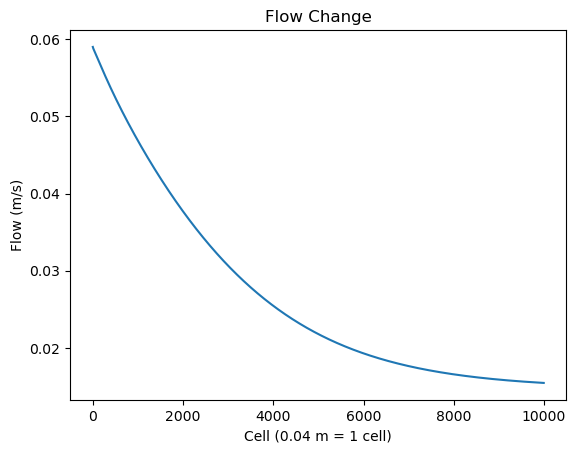

flow change: 0.04352532572063286 ; ratio (goal ~0.2) = 0.2618785936234674


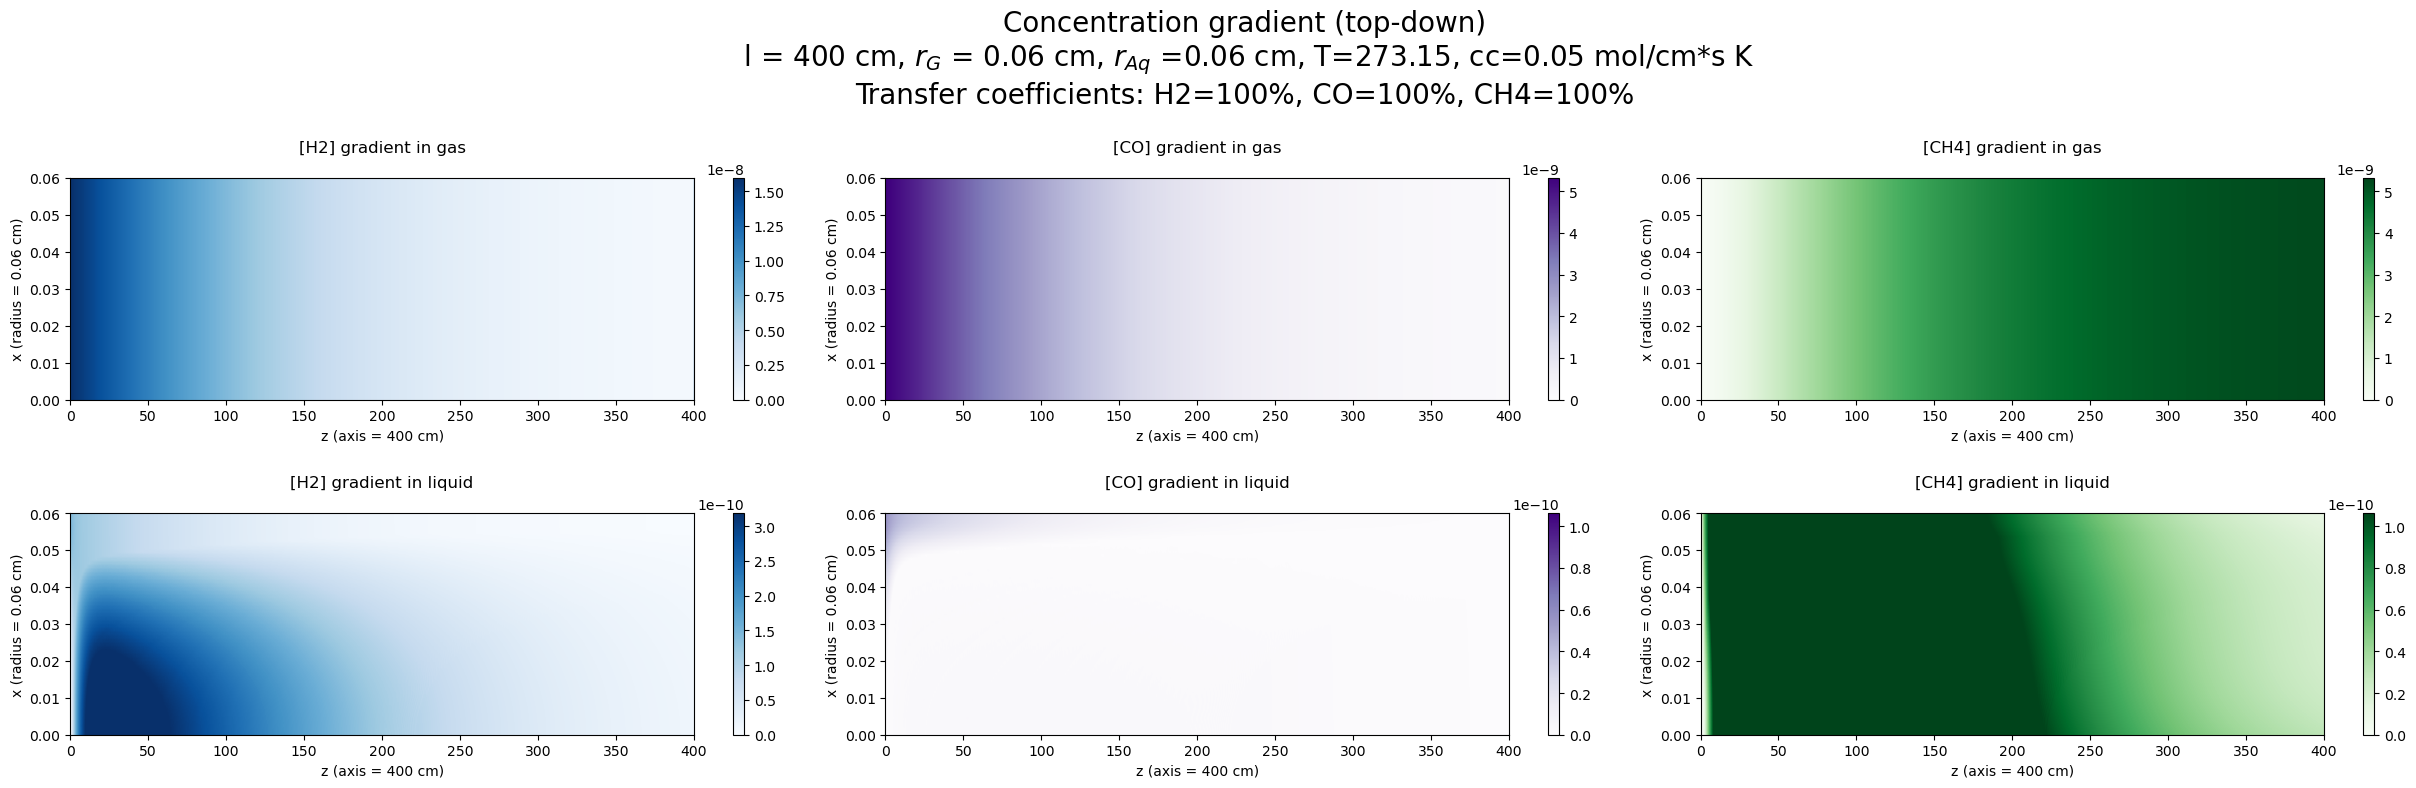

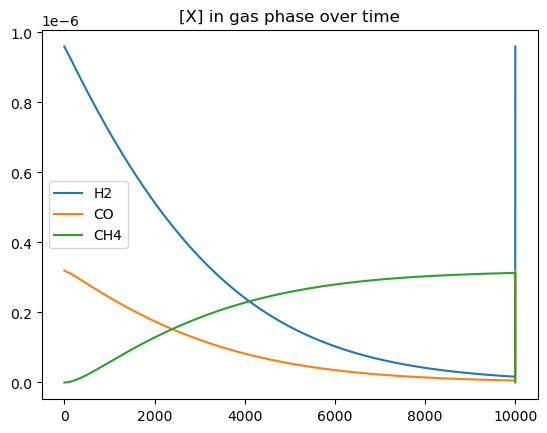

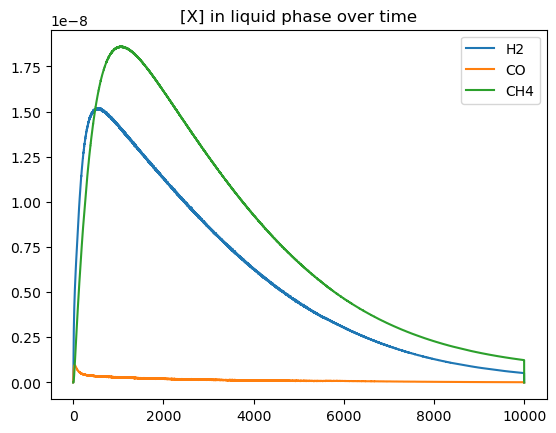

--> time to flow from one end to the other 25881.52288 s
time to run simulation: 510.0592818260193 s or 8.500988030433655 min


In [3]:
# Basic example:

tt=flow_basic2(cc=5e-2,steps=10000,carrier=0)